# Qredo tokenomics simulation - staking rewards parameters

### June 2023

## 1. Imports

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import itertools
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
forecast_length = 365*2
outfolder = os.path.realpath("../data/sim_data")

## 2. Load and process data

In [3]:
# load
df_file = os.path.join(outfolder, f"sample_by_staking_params_and_scenario.pickle")
with open(df_file, "rb") as fp:
    df = pickle.load(fp)  

# process columns
df["apr"] = 365.0*(df["total_staking_rewards"]-df["validators_rewards"])/df["staking_tvl"]
df["tvl_rate"] = df["staking_tvl"]/df["circ_supply"]
df["validator_reward_share"] = df["validator_reward_share"].round(2)
df["av_validator_reward"] = df["validators_rewards"] / df["n_validators"]
df["staking_rewards_vesting_decay_rate"] = (
    np.where(
        df["staking_rewards_vesting_decay_rate"]==np.log(2) / (6.0 * 365),
        "6yrs half-life",
        "8yrs half-life")
)
df["release_rate_a"] = df["release_rate_a"].round(1)
df["release_rate_fn"] = "a=" + df["release_rate_a"].astype(str) + " max_rate=" + df["release_rate_max"].astype(str)
df["date"] = df["iteration"].apply(lambda x: dt.datetime(2023, 6, 15)+dt.timedelta(days=x)).values

# convert units
mill_cols = ["circ_supply", 'day_vested', 'day_locked', 'day_released',"ecosystem_fund", "staking_tvl"]
df[mill_cols] = df[mill_cols]/(10**6)
thou_cols = ["validators_rewards", 'total_staking_rewards','staking_rewards_vested','staking_rewards_ecosystem']
df[thou_cols] = df[thou_cols]/(10**3)

len(df)

9460800

In [4]:
df.head(1).T

,0
iteration,0
staking_scenario,pessimistic
tipping_rate,0.2
validator_reward_share,0.7
staking_rewards_vesting_decay_rate,6yrs half-life
release_rate_a,0.8
release_rate_max,0.0006
circ_supply,568.293305
day_burned,160008000
day_vested,745.0


## 3. Reward sources

**Notes**

- 

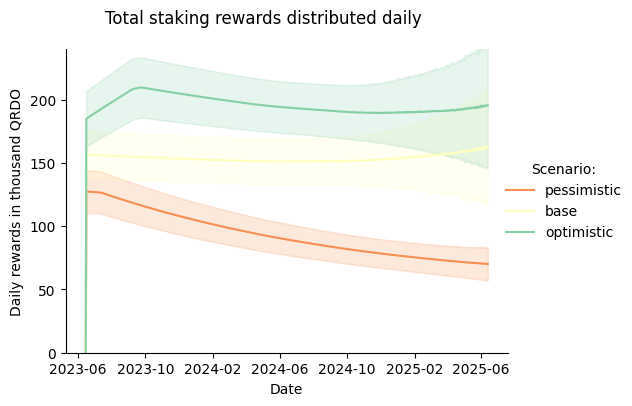

In [5]:
g = sns.relplot(data=df, x="date", y="total_staking_rewards", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Total staking rewards distributed daily")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

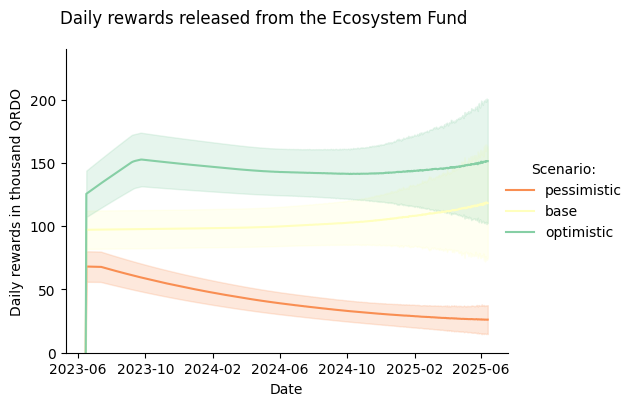

In [6]:
g = sns.relplot(data=df, x="date", y="staking_rewards_ecosystem", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Daily rewards released from the Ecosystem Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

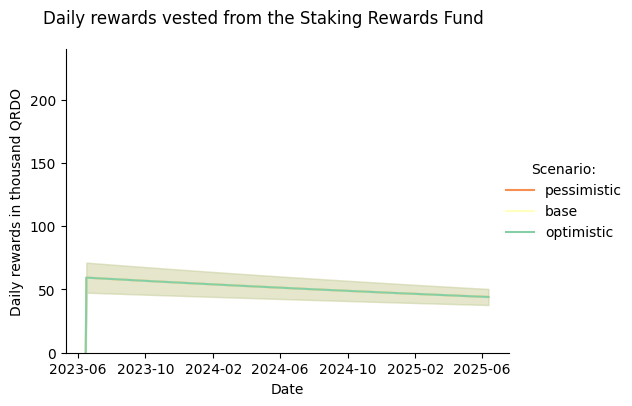

In [7]:
g = sns.relplot(data=df, x="date", y="staking_rewards_vested", hue="staking_scenario", 
                kind="line", errorbar="sd", palette="Spectral", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Scenario:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.ylim(0,240)
plt.suptitle("Daily rewards vested from the Staking Rewards Fund")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

## 4. Parameter analysis - Validator reward share

**Notes**

- 

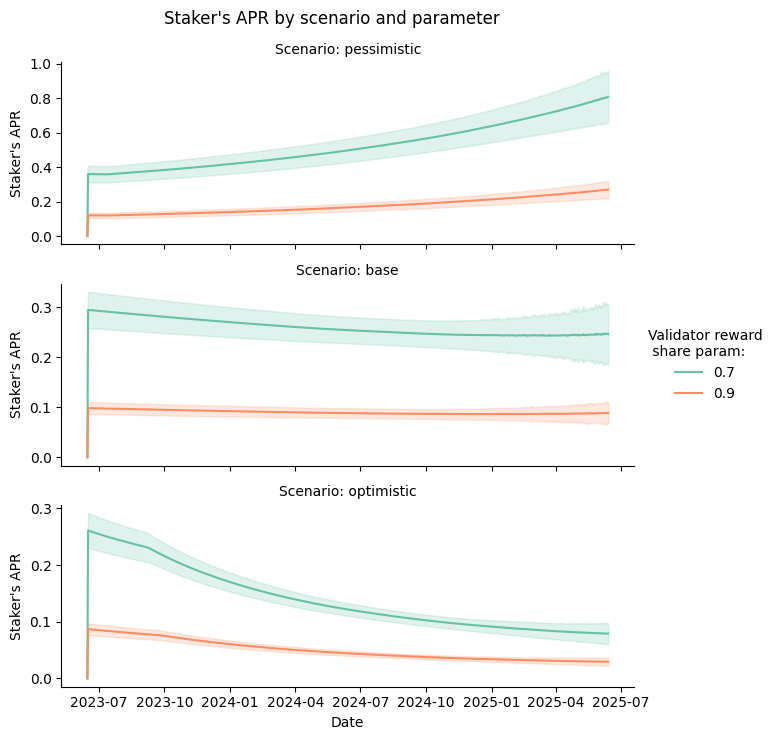

In [8]:
g = sns.relplot(data=df, x="date", y="apr", hue="validator_reward_share", row="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Staker's APR")
  .set_titles("Scenario: {row_name}")
  ._legend.set_title('Validator reward\n share param:')
)
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [9]:
temp_df = df[df["staking_scenario"]=="base"].groupby("validator_reward_share")["apr"].mean()
print(temp_df)
print(temp_df.diff())

validator_reward_share
0.7    0.259612
0.9    0.089923
Name: apr, dtype: float64
validator_reward_share
0.7         NaN
0.9   -0.169689
Name: apr, dtype: float64


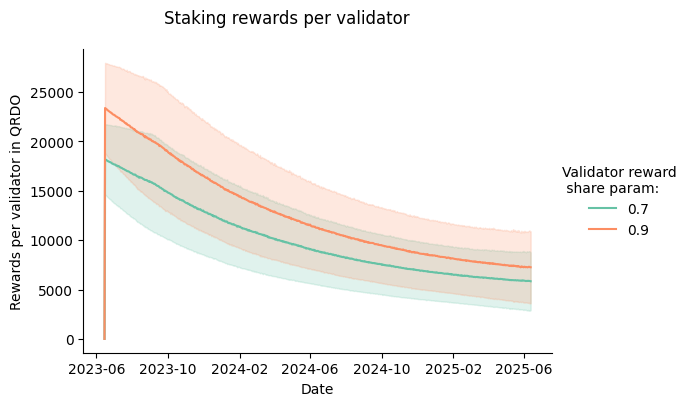

In [10]:
g = sns.relplot(data=df, x="date", y="av_validator_reward", hue="validator_reward_share",
                kind="line", errorbar="sd", palette="Set2", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Rewards per validator in QRDO")
  ._legend.set_title('Validator reward\n share param:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Staking rewards per validator")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

In [19]:
temp_df = df[df["staking_scenario"]=="base"].groupby("validator_reward_share")["av_validator_reward"].mean()
print(temp_df)
print(temp_df.diff())
print(temp_df*365*0.01)
print(temp_df*30*0.01)

validator_reward_share
0.7    10421.883899
0.9    12851.511054
Name: av_validator_reward, dtype: float64
validator_reward_share
0.7            NaN
0.9    2429.627155
Name: av_validator_reward, dtype: float64
validator_reward_share
0.7    38039.876230
0.9    46908.015347
Name: av_validator_reward, dtype: float64
validator_reward_share
0.7    3126.565170
0.9    3855.453316
Name: av_validator_reward, dtype: float64


## 5. Parameter analysis - vesting decay rate

**Notes**

- 

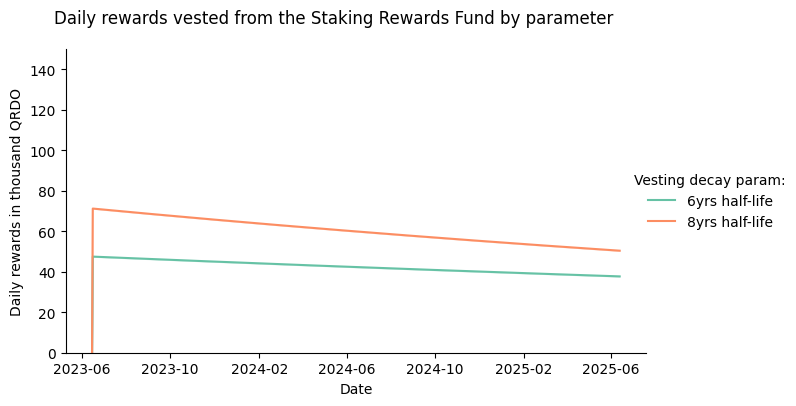

In [12]:
g = sns.relplot(data=df, x="date", y="staking_rewards_vested", hue="staking_rewards_vesting_decay_rate", 
                kind="line", errorbar="sd", palette="Set2", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Daily rewards in thousand QRDO")
  ._legend.set_title('Vesting decay param:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Daily rewards vested from the Staking Rewards Fund by parameter")
plt.ylim(0,150)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

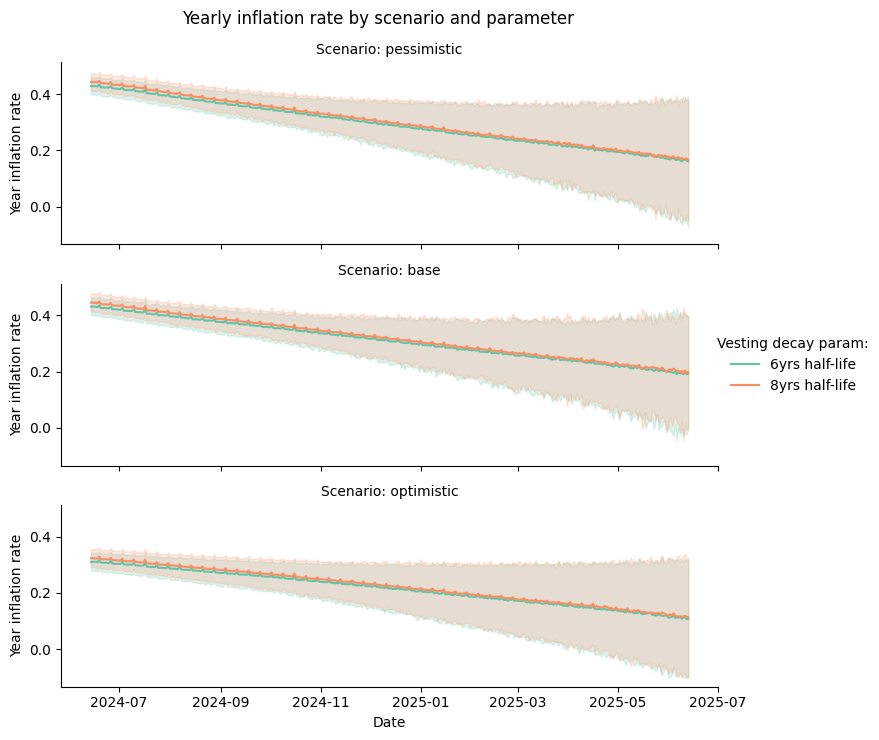

In [13]:
g = sns.relplot(data=df, x="date", y="year_inflation", hue="staking_rewards_vesting_decay_rate", row="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2)
(g.set_axis_labels("Date", "Year inflation rate")
  .set_titles("Scenario: {row_name}")
  ._legend.set_title('Vesting decay param:')
)
plt.suptitle("Yearly inflation rate by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

In [14]:
temp_df = df[df["staking_scenario"]=="base"].groupby("staking_rewards_vesting_decay_rate")["year_inflation"].mean()
print(temp_df)

staking_rewards_vesting_decay_rate
6yrs half-life    0.310867
8yrs half-life    0.319657
Name: year_inflation, dtype: float64


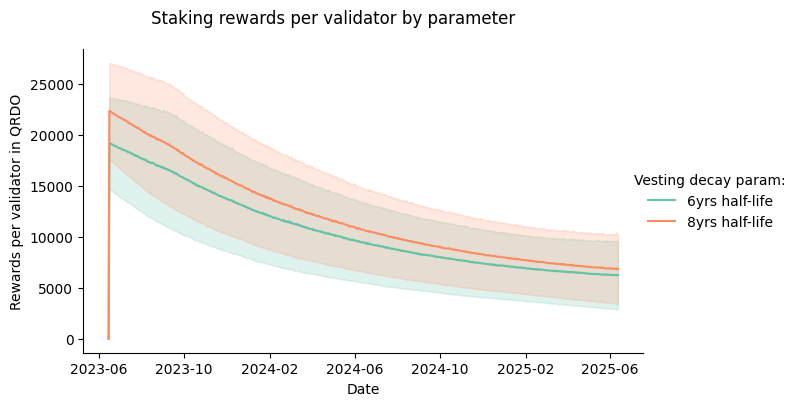

In [15]:
g = sns.relplot(data=df, x="date", y="av_validator_reward", hue="staking_rewards_vesting_decay_rate",
                kind="line", errorbar="sd", palette="Set2", height=4.1, aspect=1,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Rewards per validator in QRDO")
  ._legend.set_title('Vesting decay param:')
)
g.axes[0][0].xaxis.set_major_locator(mdates.MonthLocator(interval=4))
plt.suptitle("Staking rewards per validator by parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.18, 0.5])
plt.show()

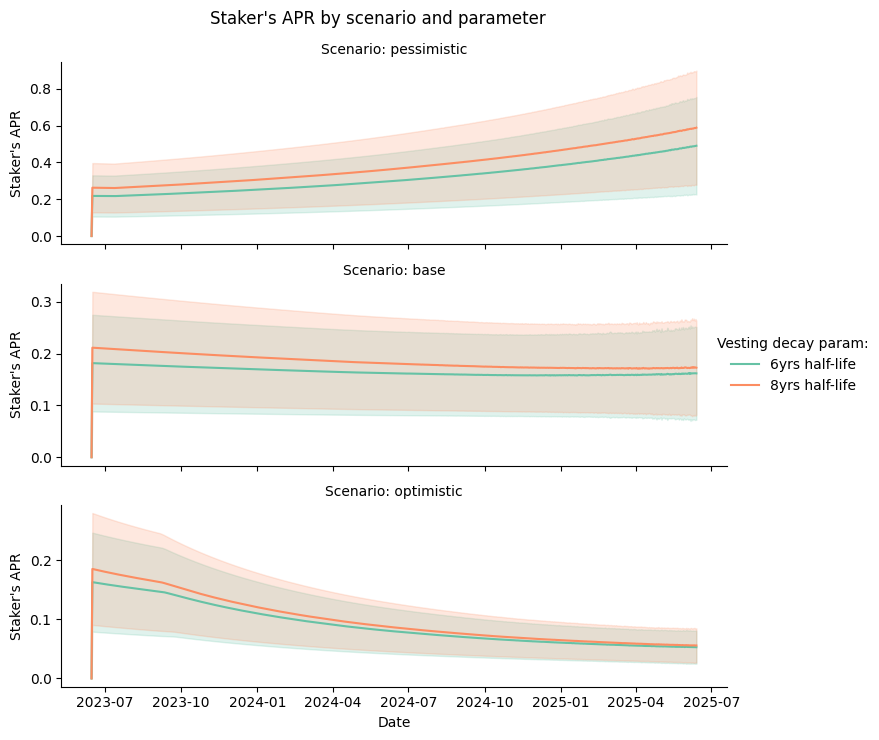

In [16]:
g = sns.relplot(data=df, x="date", y="apr", hue="staking_rewards_vesting_decay_rate", row="staking_scenario", 
                kind="line", errorbar="sd", palette="Set2", height=2.5, aspect=2,
                facet_kws={"sharey":False})
(g.set_axis_labels("Date", "Staker's APR")
  .set_titles("Scenario: {row_name}")
  ._legend.set_title('Vesting decay param:')
)
plt.suptitle("Staker's APR by scenario and parameter")
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.15, 0.5])
plt.show()

## 6. Parameter analysis - release rate function

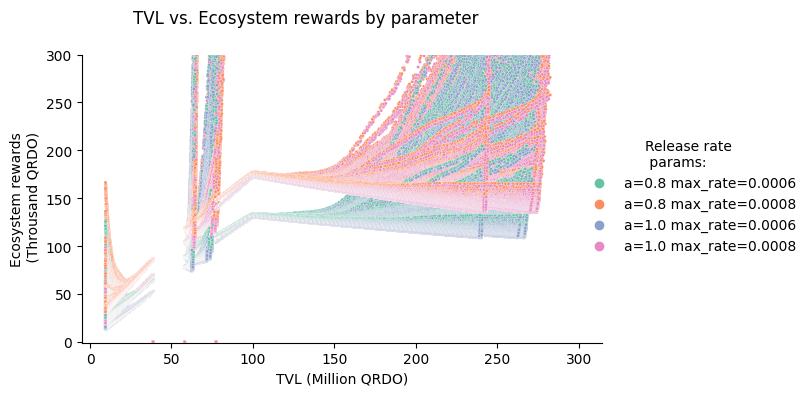

In [17]:
g = sns.relplot(data=df, x="staking_tvl", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="scatter", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("TVL (Million QRDO)", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(-1,300)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()

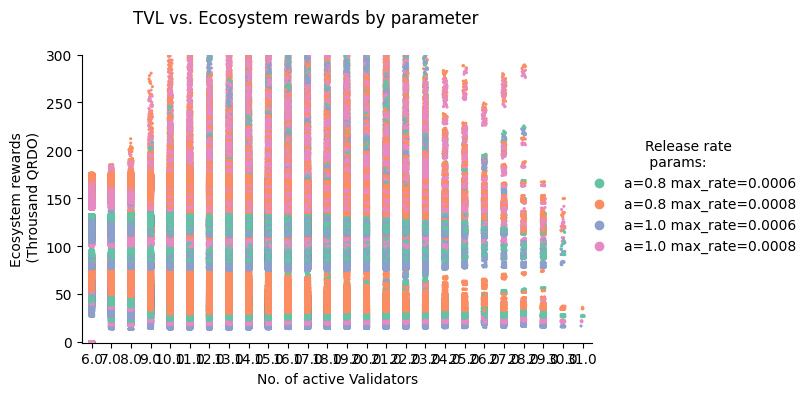

In [18]:
g = sns.catplot(data=df, x="n_validators", y="staking_rewards_ecosystem", hue="release_rate_fn",
                kind="strip", palette="Set2", height=4, aspect=1, s=5)
(g.set_axis_labels("No. of active Validators", "Ecosystem rewards\n (Throusand QRDO)")
  ._legend.set_title('Release rate \n params:')
)
plt.suptitle("TVL vs. Ecosystem rewards by parameter")
plt.ylim(-1,300)
plt.tight_layout()
g._legend.set_bbox_to_anchor([1.3, 0.5])
plt.show()